<a href="https://colab.research.google.com/github/Saideepthimolugari25/Crowd_Emotion_Detection/blob/main/gingercat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
!pip install tensorflow keras matplotlib opencv-python



In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json here



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ssanjay1187","key":"87c1872d3421b63f3a253b78441f69b3"}'}

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d msambare/fer2013
!unzip fer2013.zip -d fer2013


Streaming output truncated to the last 5000 lines.
  inflating: fer2013/train/sad/Training_65242339.jpg  
  inflating: fer2013/train/sad/Training_65267116.jpg  
  inflating: fer2013/train/sad/Training_65275626.jpg  
  inflating: fer2013/train/sad/Training_6529266.jpg  
  inflating: fer2013/train/sad/Training_65329617.jpg  
  inflating: fer2013/train/sad/Training_65338712.jpg  
  inflating: fer2013/train/sad/Training_65338797.jpg  
  inflating: fer2013/train/sad/Training_65387162.jpg  
  inflating: fer2013/train/sad/Training_65404494.jpg  
  inflating: fer2013/train/sad/Training_65426218.jpg  
  inflating: fer2013/train/sad/Training_65430136.jpg  
  inflating: fer2013/train/sad/Training_65437377.jpg  
  inflating: fer2013/train/sad/Training_6545735.jpg  
  inflating: fer2013/train/sad/Training_65463385.jpg  
  inflating: fer2013/train/sad/Training_65473985.jpg  
  inflating: fer2013/train/sad/Training_65502829.jpg  
  inflating: fer2013/train/sad/Training_65505359.jpg  
  inflating: fer

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Dataset path
dataset_path = "fer2013/train"

X, y = [], []
emotion_labels = []

# First pass: collect all emotion labels to create mapping
for emotion in os.listdir(dataset_path):
    if emotion not in emotion_labels:
        emotion_labels.append(emotion)

# Create label encoder
label_encoder = LabelEncoder()
label_encoder.fit(emotion_labels)

# Second pass: load images and encode labels
for emotion in os.listdir(dataset_path):
    emotion_path = os.path.join(dataset_path, emotion)
    if os.path.isdir(emotion_path):  # Check if it's a directory
        for img_file in os.listdir(emotion_path):
            img_path = os.path.join(emotion_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:  # Check if image was loaded successfully
                img = cv2.resize(img, (48, 48))
                X.append(img)
                y.append(emotion)  # Store the string label

# Convert string labels to numerical values
y_encoded = label_encoder.transform(y)

X = np.array(X).reshape(-1, 48, 48, 1) / 255.0
y_categorical = to_categorical(y_encoded)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y_categorical, test_size=0.2, random_state=42)
print("Training samples:", X_train.shape[0], "Validation samples:", X_val.shape[0])
print("Emotion classes:", emotion_labels)
print("Class mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

Training samples: 22967 Validation samples: 5742
Emotion classes: ['neutral', 'angry', 'fear', 'surprise', 'happy', 'sad', 'disgust']
Class mapping: {np.str_('angry'): 0, np.str_('disgust'): 1, np.str_('fear'): 2, np.str_('happy'): 3, np.str_('neutral'): 4, np.str_('sad'): 5, np.str_('surprise'): 6}


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Enhanced model architecture
model = Sequential([
    # First block
    Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(0.001), input_shape=(48,48,1)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    # Second block
    Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.4),

    # Third block
    Conv2D(256, (3,3), padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (3,3), padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.5),

    # Fourth block
    Conv2D(512, (3,3), padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (3,3), padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.5),

    Flatten(),

    # Dense layers
    Dense(1024, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.6),

    Dense(512, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.6),

    Dense(y_categorical.shape[1], activation='softmax')
])

# Enhanced optimizer with learning rate scheduling
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Enhanced callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True,
    verbose=1,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1,
    mode='max'
)

# Data augmentation (crucial for 90%+ accuracy)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Train with data augmentation
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    steps_per_epoch=len(X_train) // 64,
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


358/358 ━━━━━━━━━━━━━━━━━━━━ 60s 105ms/step - accuracy: 0.2011 - loss: 6.1442 - val_accuracy: 0.2482 - val_loss: 4.3230 - learning_rate: 0.0010
Epoch 2/100
  1/358 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.2969 - loss: 4.2984

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2969 - loss: 4.2984 - val_accuracy: 0.2435 - val_loss: 4.3142 - learning_rate: 0.0010
Epoch 3/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 44s 51ms/step - accuracy: 0.2407 - loss: 3.9408 - val_accuracy: 0.2705 - val_loss: 2.9917 - learning_rate: 0.0010
Epoch 4/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2656 - loss: 2.9423 - val_accuracy: 0.2708 - val_loss: 2.9836 - learning_rate: 0.0010
Epoch 5/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.3287 - loss: 2.7847 - val_accuracy: 0.3286 - val_loss: 2.4901 - learning_rate: 0.0010
Epoch 6/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2656 - loss: 2.5874 - val_accuracy: 0.3368 - val_loss: 2.5138 - learning_rate: 0.0010
Epoch 7/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.4003 - loss: 2.3629 - val_accuracy: 0.4047 - val_loss: 2.2475 - learning_rate: 0.0010
Epoch 8/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5781 - loss: 1.8991 -

In [ ]:
model.save("emotion_model.h5")


In [ ]:
from google.colab import files

# Save the model
model.save('emotion_model.keras')

# Download to your local machine
files.download('emotion_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving Training_10066226.jpg to Training_10066226.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted Emotion: surprise


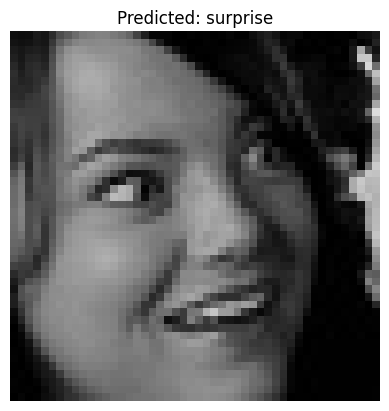

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt

uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# Preprocess image
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (48,48))
img = img.reshape(1,48,48,1)/255.0

# Predict
prediction = model.predict(img)
emotion_labels = os.listdir(dataset_path)  # same labels from training
predicted_emotion = emotion_labels[np.argmax(prediction)]

print("Predicted Emotion:", predicted_emotion)

plt.imshow(cv2.imread(img_path)[:,:,::-1])
plt.title(f"Predicted: {predicted_emotion}")
plt.axis("off")
plt.show()
